In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install spacy
!pip install pytorch-pretrained-bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!python3 -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 117.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import pickle
import numpy as np
from torch.utils.data import Dataset
from pytorch_pretrained_bert import BertTokenizer
import ast
import pandas as pd

def pad_and_truncate(sequence, maxlen, dtype='int64', padding='post', truncating='post', value=0):
    x = (np.ones(maxlen) * value).astype(dtype)
    if truncating == 'pre':
        trunc = sequence[-maxlen:]
    else:
        trunc = sequence[:maxlen]
    trunc = np.asarray(trunc, dtype=dtype)
    if padding == 'post':
        x[:len(trunc)] = trunc
    else:
        x[-len(trunc):] = trunc
    return x

class Tokenizer4Bert:
    def __init__(self, max_seq_len, pretrained_bert_name):
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_bert_name)
        self.max_seq_len = max_seq_len

    def text_to_sequence(self, text, reverse=False, padding='post', truncating='post'):
        sequence = self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(text))
        if len(sequence) == 0:
            sequence = [0]
        if reverse:
            sequence = sequence[::-1]
        return pad_and_truncate(sequence, self.max_seq_len, padding=padding, truncating=truncating)


class DatasetReader(Dataset):
    def __init__(self, fname, tokenizer):
        # fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
        # lines = fin.readlines()
        # fin.close()
        def safe_literal_eval(val):
          try:
              result = ast.literal_eval(val)
              return result if isinstance(result, list) else val
          except (ValueError, SyntaxError):
              return val  # If conversion fails, return the original value

        data = pd.read_csv(fname)
        data['headline_cleaned'] = data['headline_cleaned'].apply(safe_literal_eval)  # Apply the safe literal eval function
        print(data['headline_cleaned'][:2])
        #lines = fin['headline_cleaned'].tolist()

        fname = fname.replace('.csv','')
        fin = open(fname+'.graph', 'rb')
        idx2graph = pickle.load(fin)
        fin.close()
        fin = open(fname+'.graph_sdat', 'rb')
        idx2graph_sdat = pickle.load(fin)
        fin.close()

        #graph_id = 0
        all_data = []
        for i, row in data.iterrows():
            graph_id = i
            context = row['headline_cleaned'].lower().strip()
            label = int(row['is_sarcastic'])

            text_indices = tokenizer.text_to_sequence(context)
            text_len = np.sum(text_indices != 0)
            concat_bert_indices = tokenizer.text_to_sequence('[CLS] ' + context + " [SEP]")
            concat_segments_indices = [0] * (text_len + 2)
            concat_segments_indices = pad_and_truncate(concat_segments_indices, tokenizer.max_seq_len)


            dependency_graph = idx2graph[graph_id]
            sdat_graph = idx2graph_sdat[graph_id]

            dependency_graph = np.pad(idx2graph[graph_id], \
                ((0,tokenizer.max_seq_len-idx2graph[graph_id].shape[0]),(0,tokenizer.max_seq_len-idx2graph[graph_id].shape[0])), 'constant')

            sdat_graph = np.pad(idx2graph_sdat[graph_id], \
                ((0,tokenizer.max_seq_len-idx2graph_sdat[graph_id].shape[0]),(0,tokenizer.max_seq_len-idx2graph_sdat[graph_id].shape[0])), 'constant')

            data = {
                'text_bert_indices': concat_bert_indices,
                'bert_segments_indices': concat_segments_indices,
                'text_indices': text_indices,
                'dependency_graph': dependency_graph,
                'affective_graph': sdat_graph,
                'label': label,
            }
            graph_id += 1
            all_data.append(data)
        self.data = all_data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)


In [5]:
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn

class GraphConvolutionLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolutionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, text, adj):
        text = text.to(torch.float32)
        hidden = torch.matmul(text, self.weight)
        denom = torch.sum(adj, dim=2, keepdim=True) + 1
        output = torch.matmul(adj, hidden) / denom
        if self.bias is not None:
            return output + self.bias
        else:
            return output

In [6]:
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.nn.functional as F

class BERTGCN(nn.Module):
    def __init__(self, bert, opt):
        super(BERTGCN, self).__init__()
        self.opt = opt
        self.bert = bert
        self.gc1 = GraphConvolutionLayer(opt.bert_dim, opt.bert_dim)
        self.gc2 = GraphConvolutionLayer(opt.bert_dim, opt.bert_dim)
        self.gc3 = GraphConvolutionLayer(opt.bert_dim, opt.bert_dim)
        self.gc4 = GraphConvolutionLayer(opt.bert_dim, opt.bert_dim)
        #self.gc5 = GraphConvolutionLayer(opt.bert_dim, opt.bert_dim)
        #self.gc6 = GraphConvolutionLayer(opt.bert_dim, opt.bert_dim)
        #self.gc7 = GraphConvolutionLayer(opt.bert_dim, opt.bert_dim)
        #self.gc8 = GraphConvolutionLayer(opt.bert_dim, opt.bert_dim)

        self.fc = nn.Linear(opt.bert_dim, opt.polarities_dim)
        self.text_embed_dropout = nn.Dropout(0.3)

    def forward(self, inputs):

        text_bert_indices, bert_segments_ids, dependency_graph, affective_graph = inputs

        text_out, _ = self.bert(text_bert_indices, token_type_ids = bert_segments_ids, output_all_encoded_layers=False)

        x = F.relu(self.gc1(text_out, dependency_graph))
        x = F.relu(self.gc2(x, affective_graph))
        x = F.relu(self.gc3(text_out, dependency_graph))
        x = F.relu(self.gc4(x, affective_graph))
        #x = F.relu(self.gc5(text_out, dependency_graph))
        #x = F.relu(self.gc6(x, affective_graph))
        #x = F.relu(self.gc7(text_out, dependency_graph))
        #x = F.relu(self.gc8(x, affective_graph))

        alpha_mat = torch.matmul(x, text_out.transpose(1, 2))
        alpha = F.softmax(alpha_mat.sum(1, keepdim=True), dim=2)
        x = torch.matmul(alpha, text_out).squeeze(1) # batch_size x 2*hidden_dim
        output = self.fc(x)
        return output


In [ ]:
class DatasetReader(Dataset):
    def __init__(self, fname, tokenizer):
        # fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
        # lines = fin.readlines()
        # fin.close()
        def safe_literal_eval(val):
          try:
              result = ast.literal_eval(val)
              return result if isinstance(result, list) else val
          except (ValueError, SyntaxError):
              return val  # If conversion fails, return the original value

        data = pd.read_csv(fname)
        data['headline_cleaned'] = data['headline_cleaned'].apply(safe_literal_eval)  # Apply the safe literal eval function
        print(data['headline_cleaned'][:2])
        #lines = fin['headline_cleaned'].tolist()

        fname = fname.replace('.csv','')
        fin = open(fname+'.graph', 'rb')
        idx2graph = pickle.load(fin)
        fin.close()
        fin = open(fname+'.graph_sdat', 'rb')
        idx2graph_sdat = pickle.load(fin)
        fin.close()

        #graph_id = 0
        all_data = []
        for i, row in data.iterrows():
            graph_id = i
            context = row['headline_cleaned'].lower().strip()
            label = int(row['is_sarcastic'])

            text_indices = tokenizer.text_to_sequence(context)
            text_len = np.sum(text_indices != 0)
            concat_bert_indices = tokenizer.text_to_sequence('[CLS] ' + context + " [SEP]")
            concat_segments_indices = [0] * (text_len + 2)
            concat_segments_indices = pad_and_truncate(concat_segments_indices, tokenizer.max_seq_len)


            dependency_graph = idx2graph[graph_id]
            sdat_graph = idx2graph_sdat[graph_id]

            dependency_graph = np.pad(idx2graph[graph_id], \
                ((0,tokenizer.max_seq_len-idx2graph[graph_id].shape[0]),(0,tokenizer.max_seq_len-idx2graph[graph_id].shape[0])), 'constant')

            sdat_graph = np.pad(idx2graph_sdat[graph_id], \
                ((0,tokenizer.max_seq_len-idx2graph_sdat[graph_id].shape[0]),(0,tokenizer.max_seq_len-idx2graph_sdat[graph_id].shape[0])), 'constant')

            data = {
                'text_bert_indices': concat_bert_indices,
                'bert_segments_indices': concat_segments_indices,
                'text_indices': text_indices,
                'dependency_graph': dependency_graph,
                'affective_graph': sdat_graph,
                'label': label,
            }
            graph_id += 1
            all_data.append(data)
        self.data = all_data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpxbj12n5a
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",


0                     annoying ad turns man prowhaling
1    david cameron to scottish people i will kill m...
Name: headline_cleaned, dtype: object
0    isis recruiter excited to be talking to popula...
1    jimmy fallon could barely keep it together dur...
Name: headline_cleaned, dtype: object
cuda memory allocated: 2253696512
> n_trainable_params: 111846146, n_nontrainable_params: 0
> training arguments:
>>> model_name: bertgcn
>>> dataset: headlines
>>> optimizer: <class 'torch.optim.adam.Adam'>
>>> initializer: <function xavier_uniform_ at 0x7d6ac8733a60>
>>> lr: 2e-05
>>> dropout: 0.1
>>> l2reg: 1e-05
>>> num_epoch: 5
>>> batch_size: 16
>>> log_step: 20
>>> embed_dim: 100
>>> hidden_dim: 768
>>> bert_dim: 768
>>> pretrained_bert_name: bert-base-uncased
>>> max_seq_len: 85
>>> polarities_dim: 2
>>> hops: 3
>>> patience: 5
>>> device: cuda
>>> seed: 776
>>> valset_ratio: 0
>>> optimizers: rmsprop
>>> model_class: <class '__main__.BERTGCN'>
>>> dataset_file: {'train': '/content/drive

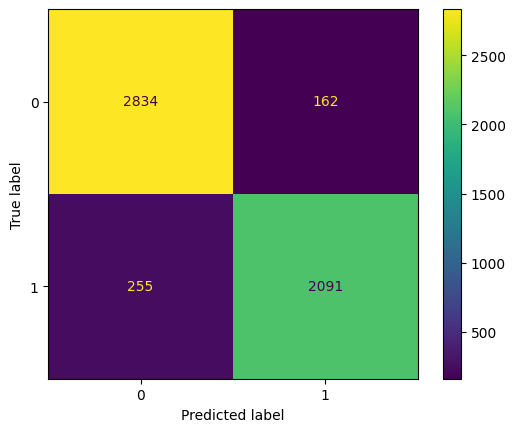

>> Test Accuracy : 0.9219, Test F1 Score : 0.9204, Test Precision  : 0.9228, Test Recall  : 0.9186


In [8]:
import argparse
import math
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from pytorch_pretrained_bert import BertModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
#from data_utils import Tokenizer4Bert, DatasetReader
#from models import BERTGCN, BERTGAT
import warnings
import logging
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

logging.basicConfig(filename = "bertgcn.log")
logger = logging.getLogger()
logger.setLevel(logging.INFO)
#logger.addHandler(logging.StreamHandler(sys.stdout))

class Instructor:
    def __init__(self, opt):
        self.opt = opt

        tokenizer = Tokenizer4Bert(opt.max_seq_len, opt.pretrained_bert_name)
        bert = BertModel.from_pretrained(opt.pretrained_bert_name)

        self.trainset = DatasetReader(opt.dataset_file['train'], tokenizer)
        self.testset = DatasetReader(opt.dataset_file['test'], tokenizer)

        if opt.valset_ratio > 0:
            valset_len = int(len(self.trainset) * opt.valset_ratio)
            self.trainset, self.valset = random_split(self.trainset, (len(self.trainset)-valset_len, valset_len))
        else:
            self.valset = self.testset

        self.val_data_loader = DataLoader(dataset=self.valset, batch_size=self.opt.batch_size, shuffle=False)
        self.train_data_loader = DataLoader(dataset=self.trainset, batch_size=self.opt.batch_size, shuffle=True)
        self.test_data_loader = DataLoader(dataset=self.testset, batch_size=self.opt.batch_size, shuffle=False)


        if opt.model_name == 'bertgcn':
            self.model = opt.model_class(bert, opt).to(opt.device)

        elif opt.model_name == 'bertgat':
            self.model = opt.model_class(bert, opt.embed_dim).to(opt.device)

        if opt.device.type == 'cuda':
            print('cuda memory allocated: {}'.format(torch.cuda.memory_allocated(device=opt.device.index)))
        self._print_args()

    def _print_args(self):
        n_trainable_params, n_nontrainable_params = 0, 0
        for p in self.model.parameters():
            n_params = torch.prod(torch.tensor(p.shape))
            if p.requires_grad:
                n_trainable_params += n_params
            else:
                n_nontrainable_params += n_params
        print('> n_trainable_params: {0}, n_nontrainable_params: {1}'.format(n_trainable_params, n_nontrainable_params))
        print('> training arguments:')
        for arg in vars(self.opt):
            print('>>> {0}: {1}'.format(arg, getattr(self.opt, arg)))

    def _reset_params(self):
        for child in self.model.children():
            if type(child) != BertModel:  # skip bert params
                for p in child.parameters():
                    if p.requires_grad:
                        if len(p.shape) > 1:
                            self.opt.initializer(p)
                        else:
                            stdv = 1. / math.sqrt(p.shape[0])
                            torch.nn.init.uniform_(p, a=-stdv, b=stdv)

    def _train(self, criterion, optimizer, train_data_loader, val_data_loader):
        max_val_f1 = 0
        global_step = 0
        path = None

        epochTrainAcc = []
        epochValAcc = []
        epochValPrecision = []
        epochValRecall = []

        for i_epoch in range(self.opt.num_epoch):
            print('>' * 100)
            print('Epoch : {}'.format(i_epoch+1))
            n_correct, n_total, loss_total, counter, tot_train_acc = 0, 0, 0, 0, 0

            # switch model to training mode
            self.model.train()
            for _, batch in enumerate(train_data_loader):
                global_step += 1

                # clear gradient accumulators
                optimizer.zero_grad()

                inputs = [batch[col].to(self.opt.device) for col in self.opt.inputs_cols]
                outputs = self.model(inputs)
                targets = batch['label'].to(self.opt.device)

                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                n_correct += (torch.argmax(outputs, -1) == targets).sum().item()
                n_total += len(outputs)
                loss_total += loss.item() * len(outputs)
                if global_step % self.opt.log_step == 0:
                    counter += 1
                    train_acc = n_correct / n_total
                    train_loss = loss_total / n_total

                    tot_train_acc += train_acc
                    print('Loss : {:.4f}, Accuracy : {:.4f}'.format(train_loss, train_acc))

            val_acc, val_f1, val_precision, val_recall = self._evaluate_acc_f1(val_data_loader)

            epochValAcc.append(val_acc)
            epochValPrecision.append(val_precision)
            epochValRecall.append(val_recall)
            epochTrainAcc.append(tot_train_acc/counter)

            print('> Validation Accuracy : {:.4f}, Validation F1 Score : {:.4f}, Validation Precision : {:.4f}, Validation Recall : {:.4f}'.format(val_acc, val_f1, val_precision, val_recall))
            if val_f1 > max_val_f1:
                max_val_f1 = val_f1
                max_val_epoch = i_epoch
                if not os.path.exists('saved_models'):
                    os.mkdir('saved_models')

                path = 'saved_models/{0}_{1}{2}'.format(self.opt.model_name, self.opt.dataset, ".pkl")
                torch.save(self.model.state_dict(), path)
                print('>> Best model saved {}'.format(path))

            if i_epoch - max_val_epoch >= self.opt.patience:
                print('>> Early stopping!')
                break

        epoch_count = range(1, len(epochTrainAcc) + 1)
        plt.plot(epoch_count, epochTrainAcc, 'r-')
        plt.plot(epoch_count, epochValAcc, 'b-')
        plt.legend(['Train Accuracy', 'Validation Accuracy'])
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.show()

        return path

    def _evaluate_acc_f1(self, data_loader):
        n_correct, n_total = 0, 0
        t_targets_all, t_outputs_all = None, None

        # switch model to evaluation mode
        self.model.eval()
        with torch.no_grad():
            for _, t_batch in enumerate(data_loader):
                t_inputs = [t_batch[col].to(self.opt.device) for col in self.opt.inputs_cols]
                t_targets = t_batch['label'].to(self.opt.device)
                t_outputs = self.model(t_inputs)

                n_correct += (torch.argmax(t_outputs, -1) == t_targets).sum().item()
                n_total += len(t_outputs)

                if t_targets_all is None:
                    t_targets_all = t_targets
                    t_outputs_all = t_outputs
                else:
                    t_targets_all = torch.cat((t_targets_all, t_targets), dim=0)
                    t_outputs_all = torch.cat((t_outputs_all, t_outputs), dim=0)

        acc = n_correct / n_total
        f1 = metrics.f1_score(
            t_targets_all.cpu(),  # Move the target tensor to the CPU
            torch.argmax(t_outputs_all, -1).cpu(),  # Move output tensor to the CPU
            labels=np.unique(torch.argmax(t_outputs_all.cpu(), -1)),  # Ensure unique labels are computed on the CPU
            average='macro'
        )

            # Calculate precision and recall
        precision = precision_score(
            t_targets_all.cpu(),
            torch.argmax(t_outputs_all, -1).cpu(),
            labels=np.unique(torch.argmax(t_outputs_all.cpu(), -1)),
            average='macro'
        )
        recall = recall_score(
            t_targets_all.cpu(),
            torch.argmax(t_outputs_all, -1).cpu(),
            labels=np.unique(torch.argmax(t_outputs_all.cpu(), -1)),
            average='macro'
        )

            # Generate confusion matrix
        cm = confusion_matrix(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu())

        # Display confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        return acc, f1,precision,recall

    def run(self):

        # Loss and Optimizer
        criterion = nn.CrossEntropyLoss()
        _params = filter(lambda p: p.requires_grad, self.model.parameters())
        optimizer = self.opt.optimizer(_params, lr=self.opt.lr, weight_decay=self.opt.l2reg)

        self._reset_params()
        best_model_path = '/content/saved_models/bertgcn_headlines.pkl' #self._train(criterion, optimizer, self.train_data_loader, self.val_data_loader)
        self.model.load_state_dict(torch.load(best_model_path))
        test_acc, test_f1, test_precision, test_recall = self._evaluate_acc_f1(self.test_data_loader)
        print('>> Test Accuracy : {:.4f}, Test F1 Score : {:.4f}, Test Precision  : {:.4f}, Test Recall  : {:.4f}'.format(test_acc, test_f1,test_precision, test_recall))


def main(**kwargs):
    # Hyper Parameters
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_name', default='bertgcn', type=str)
    parser.add_argument('--dataset', default='headlines', type=str)
    parser.add_argument('--optimizer', default='adam', type=str)
    parser.add_argument('--initializer', default='xavier_uniform_', type=str)
    parser.add_argument('--lr', default=2e-5, type=float)
    parser.add_argument('--dropout', default=0.1, type=float)
    parser.add_argument('--l2reg', default=0.00001, type=float)
    parser.add_argument('--num_epoch', default=30, type=int)
    parser.add_argument('--batch_size', default=16, type=int)
    parser.add_argument('--log_step', default=20, type=int)
    parser.add_argument('--embed_dim', default=100, type=int)
    parser.add_argument('--hidden_dim', default=768, type=int)
    parser.add_argument('--bert_dim', default=768, type=int)
    parser.add_argument('--pretrained_bert_name', default='bert-base-uncased', type=str)
    parser.add_argument('--max_seq_len', default=85, type=int)
    parser.add_argument('--polarities_dim', default=2, type=int)
    parser.add_argument('--hops', default=3, type=int)
    parser.add_argument('--patience', default=5, type=int)
    parser.add_argument('--device', default=None, type=str)
    parser.add_argument('--seed', default=776, type=int)
    parser.add_argument('--valset_ratio', default=0, type=float)


    opt_dict = vars(parser.parse_args([]))  # Start with default values
    opt_dict.update(kwargs)
    opt = argparse.Namespace(**opt_dict)
    #opt = parser.parse_args()

    if opt.seed is not None:
        random.seed(opt.seed)
        np.random.seed(opt.seed)
        torch.manual_seed(opt.seed)
        torch.cuda.manual_seed(opt.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        os.environ['PYTHONHASHSEED'] = str(opt.seed)

    model_classes = {
        'bertgcn': BERTGCN,
    }

    dataset_files = {
            'headlines': {
                'train': '/content/drive/MyDrive/CS4248/GCN/headline_cleaned_train.csv',
                'test': '/content/drive/MyDrive/CS4248/GCN/headline_cleaned_test.csv'
                }
    }

    input_colses = {
        'bertgcn': ['text_bert_indices', 'bert_segments_indices', 'dependency_graph', 'affective_graph'],
    }

    initializers = {
        'xavier_uniform_': torch.nn.init.xavier_uniform_,
        'xavier_normal_': torch.nn.init.xavier_normal_,
        'orthogonal_': torch.nn.init.orthogonal_,
    }

    optimizers = {
        'adadelta': torch.optim.Adadelta,  # default lr=1.0
        'adagrad': torch.optim.Adagrad,  # default lr=0.01
        'adam': torch.optim.Adam,  # default lr=0.001
        'adamax': torch.optim.Adamax,  # default lr=0.002
        'asgd': torch.optim.ASGD,  # default lr=0.01
        'rmsprop': torch.optim.RMSprop,  # default lr=0.01
        'sgd': torch.optim.SGD,
    }

    opt.model_class = model_classes[opt.model_name]
    opt.dataset_file = dataset_files[opt.dataset]
    opt.inputs_cols = input_colses[opt.model_name]
    opt.initializer = initializers[opt.initializer]
    opt.optimizer = optimizers[opt.optimizer]
    opt.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') \
        if opt.device is None else torch.device(opt.device)



    ins = Instructor(opt)
    ins.run()

if __name__ == '__main__' or True: # changed this line to make it trigger in the cell
    main(dataset='headlines', num_epoch=5, batch_size=16,optimizers='rmsprop')


main(dataset='headlines', num_epoch=10, batch_size=32)


>> n_trainable_params: 111846146, n_nontrainable_params: 0
>> training arguments:
>>> model_name: bertgcn
>>> dataset: headlines
>>> optimizer: <class 'torch.optim.adam.Adam'>
>>> initializer: <function xavier_uniform_ at 0x7828256259e0>
>>> lr: 2e-05
>>> dropout: 0.1
>>> l2reg: 1e-05
>>> num_epoch: 10
>>> batch_size: 32
>>> log_step: 20
>>> embed_dim: 100
>>> hidden_dim: 768
>>> bert_dim: 768
>>> pretrained_bert_name: bert-base-uncased
>>> max_seq_len: 85
>>> polarities_dim: 2
>>> hops: 3
>>> patience: 5
>>> device: cuda
>>> seed: 776
>>> valset_ratio: 0
>>> model_class: <class '__main__.BERTGCN'>

- Test Accuracy : 0.9184, Test F1 Score : 0.9168 Best epoch: 5

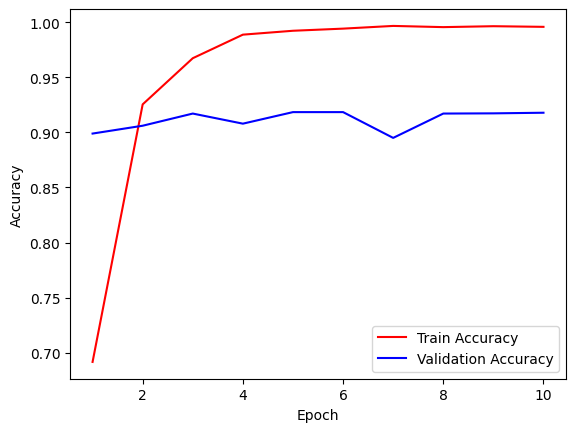

main(dataset='headlines', num_epoch=10, batch_size=16)


>> n_trainable_params: 111846146, n_nontrainable_params: 0
>> training arguments:
>>> model_name: bertgcn
>>> dataset: headlines
>>> optimizer: <class 'torch.optim.adam.Adam'>
>>> initializer: <function xavier_uniform_ at 0x7828256259e0>
>>> lr: 2e-05
>>> dropout: 0.1
>>> l2reg: 1e-05
>>> num_epoch: 10
>>> batch_size: 16
>>> log_step: 20
>>> embed_dim: 100
>>> hidden_dim: 768
>>> bert_dim: 768
>>> pretrained_bert_name: bert-base-uncased
>>> max_seq_len: 85
>>> polarities_dim: 2
>>> hops: 3
>>> patience: 5
>>> device: cuda
>>> seed: 776
>>> valset_ratio: 0
>>> model_class: <class '__main__.BERTGCN'>

>> Test Accuracy : 0.9219, Test F1 Score : 0.9204 Best epoch: 5

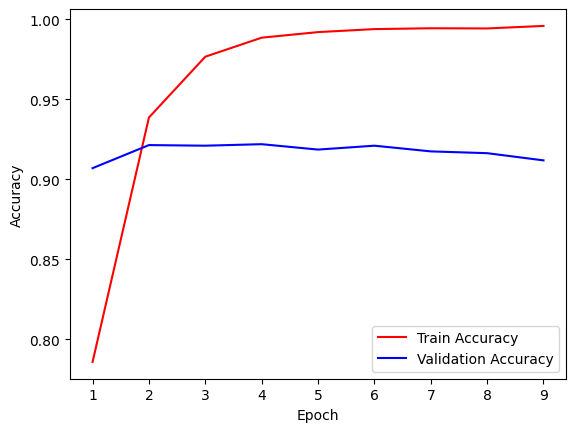

> n_trainable_params: 111846146, n_nontrainable_params: 0
>> training arguments:
>>> model_name: bertgcn
>>> dataset: headlines
>>> optimizer: <class 'torch.optim.adam.Adam'>
>>> initializer: <function xavier_uniform_ at 0x7b0a1a6234c0>
>>> lr: 2e-05
>>> dropout: 0.1
>>> l2reg: 1e-05
>>> num_epoch: 10
>>> batch_size: 16
>>> log_step: 20
>>> embed_dim: 100
>>> hidden_dim: 768
>>> bert_dim: 768
>>> pretrained_bert_name: bert-base-uncased
>>> max_seq_len: 85
>>> polarities_dim: 2
>>> hops: 3
>>> patience: 5
>>> device: cuda
>>> seed: 776
>>> valset_ratio: 0
>>> optimizers: rmsprop
>>> model_class: <class '__main__.BERTGCN'>

Test Accuracy : 0.9219, Test F1 Score : 0.9204

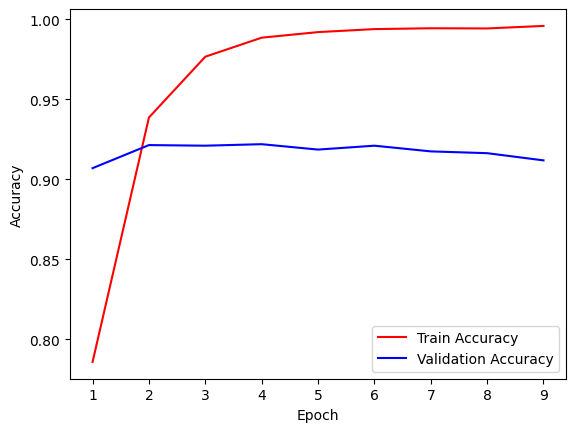



| Batch Size | Accuracy | F1 Score | Best Epoch | Notes                             |
|------------|----------|----------|------------|-----------------------------------|
| 32         | 0.9184   | 0.9168   | 5          | Optimizer: Adam                   |
| 16         | 0.9219   | 0.9204   | 5          | Optimizer: Adam                   |
| 16         | 0.9219   | 0.9204   | 5          | Optimizer: RMSprop (mentioned)    |


# Archive

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00


In [ ]:
import pickle
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
import pandas as pd

# 加载保存的图数据
def load_graphs(dep_path, aff_path):
    with open(dep_path, 'rb') as f:
        dep_graphs = pickle.load(f)  # 依存图
    with open(aff_path, 'rb') as f:
        aff_graphs = pickle.load(f)  # 情感图
    return dep_graphs, aff_graphs

# 假设你的标签文件是 CSV 格式
def load_labels(label_file):
    df = pd.read_csv(label_file)
    return df['is_sarcastic'].tolist()

# 生成 PyTorch Geometric 数据集
def create_dataset(dep_graphs, aff_graphs, labels):
    data_list = []
    feature_dim = 50
    for idx, dep_adj in dep_graphs.items():
        num_nodes = dep_adj.shape[0]
        aff_adj = aff_graphs[idx]
        y = torch.tensor([labels[idx]], dtype=torch.long)

        # 生成随机节点特征 (num_nodes, feature_dim)
        x = torch.rand((num_nodes, feature_dim), dtype=torch.float)

        # 生成邻接矩阵索引
        edge_index_dep = torch.tensor(np.array(dep_adj.nonzero()), dtype=torch.long)
        edge_index_aff = torch.tensor(np.array(aff_adj.nonzero()), dtype=torch.long)

        # 构造 Data 对象
        data = Data(x=x, edge_index=edge_index_dep, y=y)
        data.edge_index_aff = edge_index_aff  # 额外存储情感图的邻接矩阵
        data_list.append(data)

    return data_list

# 加载数据
dep_graphs, aff_graphs = load_graphs('/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/featured_nltk.graph', '/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/featured_nltk.graph_sdat')
labels = load_labels('/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/features_nltk.csv')

# 构造数据集
dataset = create_dataset(dep_graphs, aff_graphs, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"数据集大小: {len(dataset)} 条样本")


数据集大小: 26709 条样本


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
print(dataset.head)

Data(x=[10, 10], edge_index=[2, 28], y=[1], edge_index_aff=[2, 23])


In [ ]:
class MultiGraphGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MultiGraphGCN, self).__init__()
        self.conv1_dep = GCNConv(in_channels, hidden_channels)
        self.conv2_dep = GCNConv(hidden_channels, out_channels)
        self.conv1_aff = GCNConv(in_channels, hidden_channels)
        self.conv2_aff = GCNConv(hidden_channels, out_channels)
        self.fc = torch.nn.Linear(out_channels * 2, out_channels)  # 合并后再线性映射

    def forward(self, x, edge_index_dep, edge_index_aff):
        # 依赖图卷积
        x_dep = self.conv1_dep(x, edge_index_dep)
        x_dep = F.relu(x_dep)
        x_dep = self.conv2_dep(x_dep, edge_index_dep)

        # 情感图卷积
        x_aff = self.conv1_aff(x, edge_index_aff)
        x_aff = F.relu(x_aff)
        x_aff = self.conv2_aff(x_aff, edge_index_aff)

        # 合并两个图卷积的输出
        x_combined = torch.cat([x_dep, x_aff], dim=1)
        x_combined = self.fc(x_combined)

        return F.log_softmax(x_combined, dim=1)

In [ ]:
from torch_geometric.nn import GCNConv
# 定义模型参数
in_channels = 50  # 节点特征维度
hidden_channels = 16
out_channels = 2  # 二分类问题

# 初始化模型
model = MultiGraphGCN(in_channels, hidden_channels, out_channels)

# 设置优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# 训练模型
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_index_aff)
        loss = loss_fn(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
# 评估模型
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            out = model(data.x, data.edge_index, data.edge_index_aff)
            pred = out.argmax(dim=1)
            correct += (pred == data.y.view(-1)).sum().item()
            total += data.num_graphs
    return correct / total

# 训练循环
num_epochs = 200
for epoch in range(num_epochs):
    loss = train(model, dataloader, optimizer, loss_fn)
    accuracy = evaluate(model, dataloader)
    print(f'Epoch {epoch + 1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

ValueError: Expected input batch_size (114) to match target batch_size (16).

In [ ]:
import pickle
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
import torch_geometric.loader as DataLoader
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

# 加载保存的图数据
def load_graphs(dep_path, aff_path):
    with open(dep_path, 'rb') as f:
        dep_graphs = pickle.load(f)  # 依存图
    with open(aff_path, 'rb') as f:
        aff_graphs = pickle.load(f)  # 情感图
    return dep_graphs, aff_graphs

# 假设你的标签文件是 CSV 格式
def load_labels(label_file):
    df = pd.read_csv(label_file)
    return df['is_sarcastic'].tolist()

# 生成 PyTorch Geometric 数据集
def create_dataset(dep_graphs, aff_graphs, labels):
    data_list = []
    feature_dim = 50
    for idx, dep_adj in dep_graphs.items():
        num_nodes = dep_adj.shape[0]
        aff_adj = aff_graphs[idx]
        y = torch.tensor([labels[idx]], dtype=torch.long)

        # 生成随机节点特征 (num_nodes, feature_dim)
        x = torch.rand((num_nodes, feature_dim), dtype=torch.float)

        # 生成邻接矩阵索引
        edge_index_dep = torch.tensor(np.array(dep_adj.nonzero()), dtype=torch.long)
        edge_index_aff = torch.tensor(np.array(aff_adj.nonzero()), dtype=torch.long)

        # 构造 Data 对象
        data = Data(x=x, edge_index=edge_index_dep, y=y)
        data.edge_index_aff = edge_index_aff  # 额外存储情感图的邻接矩阵
        data_list.append(data)

    return data_list

# 定义多图卷积网络模型
class MultiGraphGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MultiGraphGCN, self).__init__()
        self.conv1_dep = GCNConv(in_channels, hidden_channels)
        self.conv2_dep = GCNConv(hidden_channels, hidden_channels)
        self.conv1_aff = GCNConv(in_channels, hidden_channels)
        self.conv2_aff = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels * 2, out_channels)  # 合并后再线性映射

    def forward(self, x, edge_index_dep, edge_index_aff, batch):
        # 依赖图卷积
        x_dep = self.conv1_dep(x, edge_index_dep)
        x_dep = F.relu(x_dep)
        x_dep = self.conv2_dep(x_dep, edge_index_dep)

        # 情感图卷积
        x_aff = self.conv1_aff(x, edge_index_aff)
        x_aff = F.relu(x_aff)
        x_aff = self.conv2_aff(x_aff, edge_index_aff)

        # 合并两个图卷积的输出
        x_combined = torch.cat([x_dep, x_aff], dim=1)
        x_combined = global_mean_pool(x_combined, batch)  # 对每个图进行池化
        x_combined = self.fc(x_combined)

        return F.log_softmax(x_combined, dim=1)

# 加载数据
dep_graphs, aff_graphs = load_graphs('/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/featured_nltk.graph', '/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/featured_nltk.graph_sdat')
labels = load_labels('/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/preprocessed_stopwords_removed.csv')

# 构造数据集
dataset = create_dataset(dep_graphs, aff_graphs, labels)
dataloader = DataLoader.DataLoader(dataset, batch_size=16, shuffle=True)

print(f"数据集大小: {len(dataset)} 条样本")

# 定义模型参数
in_channels = 50  # 节点特征维度
hidden_channels = 16
out_channels = 2  # 二分类问题

# 初始化模型
model = MultiGraphGCN(in_channels, hidden_channels, out_channels)

# 设置优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# 训练模型
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_index_aff, data.batch)

        # 检查输出和目标的大小是否匹配
        if out.size(0) != data.y.size(0):
            print(f"Skipping batch with out.size(0)={out.size(0)} and data.y.size(0)={data.y.size(0)}")
            continue

        loss = loss_fn(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# 评估模型
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            out = model(data.x, data.edge_index, data.edge_index_aff, data.batch)

            # 检查输出和目标的大小是否匹配
            if out.size(0) != data.y.size(0):
                print(f"Skipping batch with out.size(0)={out.size(0)} and data.y.size(0)={data.y.size(0)}")
                continue

            pred = out.argmax(dim=1)
            correct += (pred == data.y.view(-1)).sum().item()
            total += data.num_graphs
    return correct / total

# 训练循环
num_epochs = 200
for epoch in range(num_epochs):
    loss = train(model, dataloader, optimizer, loss_fn)
    accuracy = evaluate(model, dataloader)
    print(f'Epoch {epoch + 1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

数据集大小: 26709 条样本
Skipping batch with out.size(0)=15 and data.y.size(0)=16
Epoch 1, Loss: 0.6863, Accuracy: 0.5610
Epoch 2, Loss: 0.6864, Accuracy: 0.5610
Epoch 3, Loss: 0.6865, Accuracy: 0.5610
Epoch 4, Loss: 0.6869, Accuracy: 0.5610
Epoch 5, Loss: 0.6863, Accuracy: 0.5610
Epoch 6, Loss: 0.6867, Accuracy: 0.5610
Epoch 7, Loss: 0.6866, Accuracy: 0.5610
Epoch 8, Loss: 0.6868, Accuracy: 0.5610
Epoch 9, Loss: 0.6862, Accuracy: 0.5610
Epoch 10, Loss: 0.6866, Accuracy: 0.5610
Epoch 11, Loss: 0.6870, Accuracy: 0.5610
Epoch 12, Loss: 0.6867, Accuracy: 0.5610
Epoch 13, Loss: 0.6861, Accuracy: 0.5610
Epoch 14, Loss: 0.6866, Accuracy: 0.5610
Epoch 15, Loss: 0.6868, Accuracy: 0.5610
Epoch 16, Loss: 0.6868, Accuracy: 0.5610
Epoch 17, Loss: 0.6872, Accuracy: 0.5610
Epoch 18, Loss: 0.6865, Accuracy: 0.5610
Skipping batch with out.size(0)=15 and data.y.size(0)=16
Epoch 19, Loss: 0.6864, Accuracy: 0.5610
Epoch 20, Loss: 0.6868, Accuracy: 0.5610
Epoch 21, Loss: 0.6869, Accuracy: 0.5610
Epoch 22, Loss: 0

KeyboardInterrupt: 

In [ ]:
import pickle
import numpy as np
import torch
from torch_geometric.loader import  DataLoader
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split

# 加载保存的图数据
def load_graphs(dep_path, aff_path):
    with open(dep_path, 'rb') as f:
        dep_graphs = pickle.load(f)  # 依存图
    with open(aff_path, 'rb') as f:
        aff_graphs = pickle.load(f)  # 情感图
    return dep_graphs, aff_graphs

# 假设你的标签文件是 CSV 格式
def load_labels(label_file):
    df = pd.read_csv(label_file)
    return df['is_sarcastic'].tolist()

# 生成 PyTorch Geometric 数据集
def create_dataset(dep_graphs, aff_graphs, labels):
    data_list = []
    feature_dim = 50
    for idx, dep_adj in dep_graphs.items():
        num_nodes = dep_adj.shape[0]
        aff_adj = aff_graphs[idx]
        y = torch.tensor([labels[idx]], dtype=torch.long)

        # 生成随机节点特征 (num_nodes, feature_dim)
        x = torch.rand((num_nodes, feature_dim), dtype=torch.float)

        # 生成邻接矩阵索引
        edge_index_dep = torch.tensor(np.array(dep_adj.nonzero()), dtype=torch.long)
        edge_index_aff = torch.tensor(np.array(aff_adj.nonzero()), dtype=torch.long)

        # 构造 Data 对象
        data = Data(x=x, edge_index=edge_index_dep, y=y)
        data.edge_index_aff = edge_index_aff  # 额外存储情感图的邻接矩阵
        data_list.append(data)

    return data_list

# 定义多图卷积网络模型
class MultiGraphGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MultiGraphGCN, self).__init__()
        self.conv1_dep = GCNConv(in_channels, hidden_channels)
        self.conv2_dep = GCNConv(hidden_channels, hidden_channels)
        self.conv1_aff = GCNConv(in_channels, hidden_channels)
        self.conv2_aff = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels * 2, out_channels)  # 合并后再线性映射

    def forward(self, x, edge_index_dep, edge_index_aff, batch):
        # 依赖图卷积
        x_dep = self.conv1_dep(x, edge_index_dep)
        x_dep = F.relu(x_dep)
        x_dep = self.conv2_dep(x_dep, edge_index_dep)

        # 情感图卷积
        x_aff = self.conv1_aff(x, edge_index_aff)
        x_aff = F.relu(x_aff)
        x_aff = self.conv2_aff(x_aff, edge_index_aff)

        # 合并两个图卷积的输出
        x_combined = torch.cat([x_dep, x_aff], dim=1)
        x_combined = global_mean_pool(x_combined, batch)  # 对每个图进行池化
        x_combined = self.fc(x_combined)
        return F.log_softmax(x_combined, dim=1)

# 加载数据
dep_graphs, aff_graphs = load_graphs('/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/headline_cleaned.graph', '/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/headline_cleaned.graph_sdat')
labels = load_labels('/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/preprocessed_stopwords_removed.csv')

# 构造数据集
dataset = create_dataset(dep_graphs, aff_graphs, labels)

# 将数据集分成训练集和测试集
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"训练集大小: {len(train_dataset)} 条样本")
print(f"测试集大小: {len(test_dataset)} 条样本")

# 定义模型参数
in_channels = 50  # 节点特征维度
hidden_channels = 16
out_channels = 2  # 二分类问题

# 初始化模型
model = MultiGraphGCN(in_channels, hidden_channels, out_channels)

# 设置优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# 训练模型
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_index_aff, data.batch)

        # 检查输出和目标的大小是否匹配
        if out.size(0) != data.y.size(0):
            print(f"Skipping batch with out.size(0)={out.size(0)} and data.y.size(0)={data.y.size(0)}")
            continue

        loss = loss_fn(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# 评估模型
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            out = model(data.x, data.edge_index, data.edge_index_aff, data.batch)

            # 检查输出和目标的大小是否匹配
            if out.size(0) != data.y.size(0):
                print(f"Skipping batch with out.size(0)={out.size(0)} and data.y.size(0)={data.y.size(0)}")
                continue

            pred = out.argmax(dim=1)
            correct += (pred == data.y.view(-1)).sum().item()
            total += data.num_graphs
    return correct / total

# 训练循环
num_epochs = 200
for epoch in range(num_epochs):
    loss = train(model, train_loader, optimizer, loss_fn)
    train_accuracy = evaluate(model, train_loader)
    test_accuracy = evaluate(model, test_loader)
    print(f'Epoch {epoch + 1}, Loss: {loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

训练集大小: 21367 条样本
测试集大小: 5342 条样本
Epoch 1, Loss: 0.6876, Train Accuracy: 0.5611, Test Accuracy: 0.5608
Epoch 2, Loss: 0.6866, Train Accuracy: 0.5611, Test Accuracy: 0.5608
Epoch 3, Loss: 0.6866, Train Accuracy: 0.5611, Test Accuracy: 0.5608
Epoch 4, Loss: 0.6866, Train Accuracy: 0.4389, Test Accuracy: 0.4392
Epoch 5, Loss: 0.6874, Train Accuracy: 0.5611, Test Accuracy: 0.5608
Epoch 6, Loss: 0.6863, Train Accuracy: 0.5611, Test Accuracy: 0.5608
Epoch 7, Loss: 0.6867, Train Accuracy: 0.5611, Test Accuracy: 0.5608
Epoch 8, Loss: 0.6866, Train Accuracy: 0.5611, Test Accuracy: 0.5608
Epoch 9, Loss: 0.6867, Train Accuracy: 0.5611, Test Accuracy: 0.5608
Epoch 10, Loss: 0.6865, Train Accuracy: 0.5611, Test Accuracy: 0.5608
Epoch 11, Loss: 0.6866, Train Accuracy: 0.5611, Test Accuracy: 0.5608


KeyboardInterrupt: 

In [ ]:
import pickle
import numpy as np
import torch
from torch_geometric.loader import DataLoader
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# 加载保存的图数据
def load_graphs(dep_path, aff_path):
    with open(dep_path, 'rb') as f:
        dep_graphs = pickle.load(f)  # 依存图
    with open(aff_path, 'rb') as f:
        aff_graphs = pickle.load(f)  # 情感图
    return dep_graphs, aff_graphs

# 假设你的标签文件是 CSV 格式
def load_labels(label_file):
    df = pd.read_csv(label_file)
    return df['is_sarcastic'].tolist()

# 生成 PyTorch Geometric 数据集
def create_dataset(dep_graphs, aff_graphs, labels):
    data_list = []
    feature_dim = 50
    for idx, dep_adj in dep_graphs.items():
        num_nodes = dep_adj.shape[0]
        aff_adj = aff_graphs[idx]
        y = torch.tensor([labels[idx]], dtype=torch.float)  # Note: Changed to float for BCEWithLogitsLoss

        # 生成随机节点特征 (num_nodes, feature_dim)
        x = torch.rand((num_nodes, feature_dim), dtype=torch.float)

        # 生成邻接矩阵索引
        edge_index_dep = torch.tensor(np.array(dep_adj.nonzero()), dtype=torch.long)
        edge_index_aff = torch.tensor(np.array(aff_adj.nonzero()), dtype=torch.long)

        # 构造 Data 对象
        data = Data(x=x, edge_index=edge_index_dep, y=y)
        data.edge_index_aff = edge_index_aff  # 额外存储情感图的邻接矩阵
        data_list.append(data)

    return data_list

# 增加模型复杂度
class MultiGraphGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(MultiGraphGCN, self).__init__()
        self.conv1_dep = GCNConv(in_channels, hidden_channels)
        self.conv2_dep = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv1_aff = GCNConv(in_channels, hidden_channels)
        self.conv2_aff = GCNConv(hidden_channels, hidden_channels * 2)
        self.fc = torch.nn.Linear(hidden_channels * 4, 1)  # 增加输出维度

    def forward(self, x, edge_index_dep, edge_index_aff, batch):
        x_dep = self.conv1_dep(x, edge_index_dep)
        x_dep = F.relu(x_dep)
        x_dep = self.conv2_dep(x_dep, edge_index_dep)

        x_aff = self.conv1_aff(x, edge_index_aff)
        x_aff = F.relu(x_aff)
        x_aff = self.conv2_aff(x_aff, edge_index_aff)

        x_combined = torch.cat([x_dep, x_aff], dim=1)
        x_combined = global_mean_pool(x_combined, batch)
        x_combined = self.fc(x_combined)
        return x_combined

# 加载数据
dep_graphs, aff_graphs = load_graphs('/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/headline_cleaned.graph', '/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/headline_cleaned.graph_sdat')
labels = load_labels('/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/preprocessed_stopwords_removed.csv')

# 构造数据集
dataset = create_dataset(dep_graphs, aff_graphs, labels)

# 将数据集分成训练集和测试集
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"训练集大小: {len(train_dataset)} 条样本")
print(f"测试集大小: {len(test_dataset)} 条样本")

# 定义模型参数
in_channels = 50  # 节点特征维度
hidden_channels = 16

# 初始化模型
model = MultiGraphGCN(in_channels, hidden_channels)

# 设置优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.BCEWithLogitsLoss()

# 训练模型
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_index_aff, data.batch).view(-1)
        loss = loss_fn(out, data.y.float().view(-1))
        loss.backward()
        print(f"Gradients: {[param.grad for param in model.parameters()]}")  # 打印梯度
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# 评估模型
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in dataloader:
            out = model(data.x, data.edge_index, data.edge_index_aff, data.batch).view(-1)

            # 检查输出和目标的大小是否匹配
            if out.size(0) != data.y.size(0):
                print(f"Skipping batch with out.size(0)={out.size(0)} and data.y.size(0)={data.y.size(0)}")
                continue

            pred = torch.sigmoid(out) > 0.5
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds)
    print(all_preds)
    print(all_labels)
    return accuracy, f1

# 训练循环
num_epochs = 3
for epoch in range(num_epochs):
    loss = train(model, train_loader, optimizer, loss_fn)
    train_accuracy, train_f1 = evaluate(model, train_loader)
    test_accuracy, test_f1 = evaluate(model, test_loader)
    print(f'Epoch {epoch + 1}, Loss: {loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')

Streaming output truncated to the last 5000 lines.
         -1.7963e-04, -1.5987e-04, -2.8022e-04, -2.0803e-04, -7.5239e-05,
         -1.6782e-04, -2.2600e-04, -1.0574e-04, -3.2554e-04, -2.6819e-04,
         -2.3795e-04, -2.2492e-04, -2.5607e-04, -2.3165e-04, -7.5822e-05],
        [-3.8020e-04, -4.0378e-04, -4.6075e-04, -5.5734e-04, -4.4090e-04,
         -5.1774e-04, -5.1462e-04, -4.7237e-04, -4.4912e-04, -4.5170e-04,
         -4.1601e-04, -5.2522e-04, -5.7127e-04, -5.4767e-04, -3.8493e-04,
         -4.8665e-04, -4.6254e-04, -4.5900e-04, -4.3185e-04, -4.4414e-04,
         -5.2888e-04, -4.0204e-04, -3.7513e-04, -4.1980e-04, -4.9478e-04,
         -5.2851e-04, -3.9840e-04, -4.9150e-04, -3.8858e-04, -4.6910e-04,
         -4.5766e-04, -4.2232e-04, -5.6235e-04, -4.1790e-04, -4.3452e-04,
         -5.0987e-04, -4.3990e-04, -4.3889e-04, -4.8208e-04, -3.4810e-04,
         -4.3856e-04, -4.7338e-04, -4.4465e-04, -5.0030e-04, -5.0957e-04,
         -4.8261e-04, -4.1623e-04, -4.5676e-04, -4.9446e-04,

KeyboardInterrupt: 

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
# 加载数据
dep_graphs, aff_graphs = load_graphs('/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/headline_cleaned.graph', '/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/headline_cleaned.graph_sdat')
labels = load_labels('/content/drive/MyDrive/CS4248/CS4248_Group8_SarcasmDetection/data/preprocessed_stopwords_removed.csv')
# 可视化图结构
def visualize_graph(adj_matrix, title):
    # 将邻接矩阵转换为 NetworkX 图对象
    G = nx.from_numpy_array(adj_matrix)
    pos = nx.spring_layout(G)  # 使用 spring 布局算法
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.title(title)
    plt.show()

In [ ]:
print(dep_graphs[2])

[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


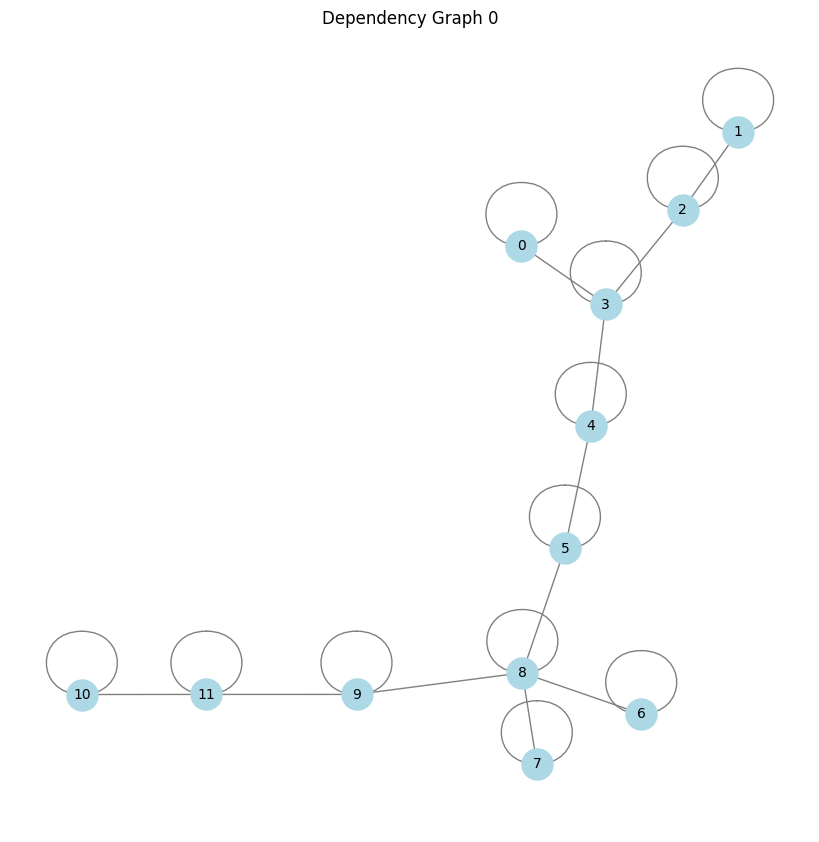

(12, 12)


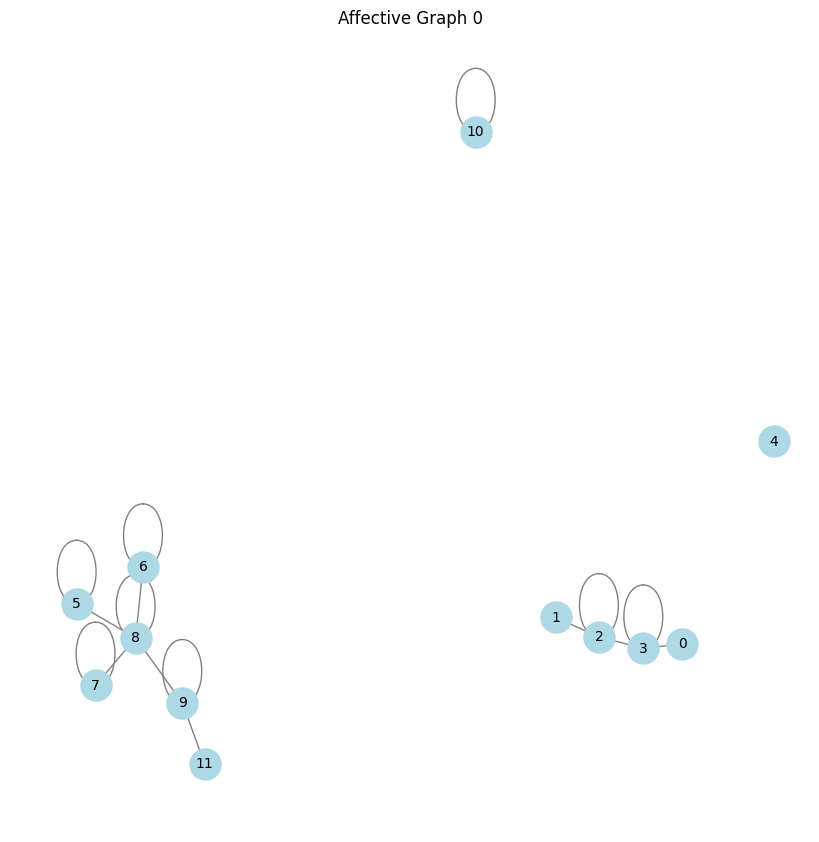

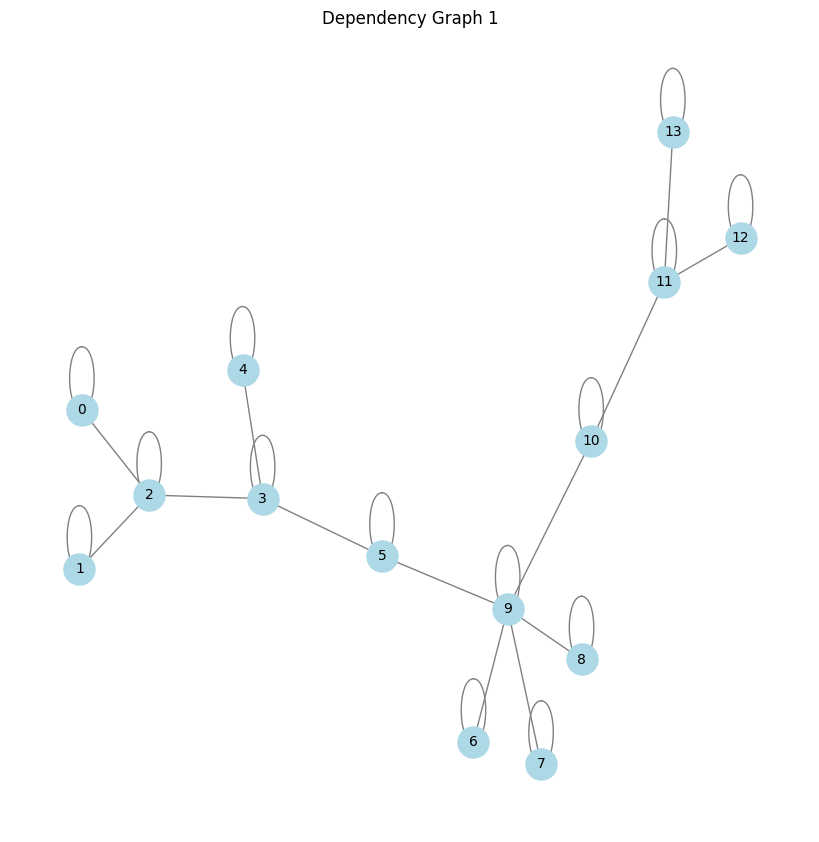

(14, 14)


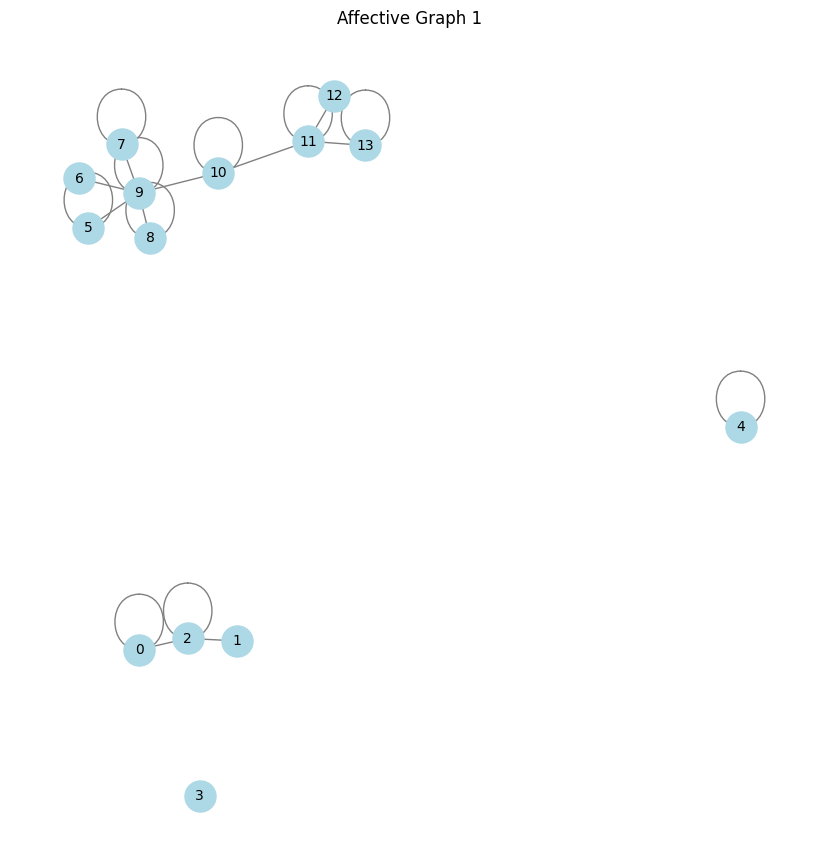

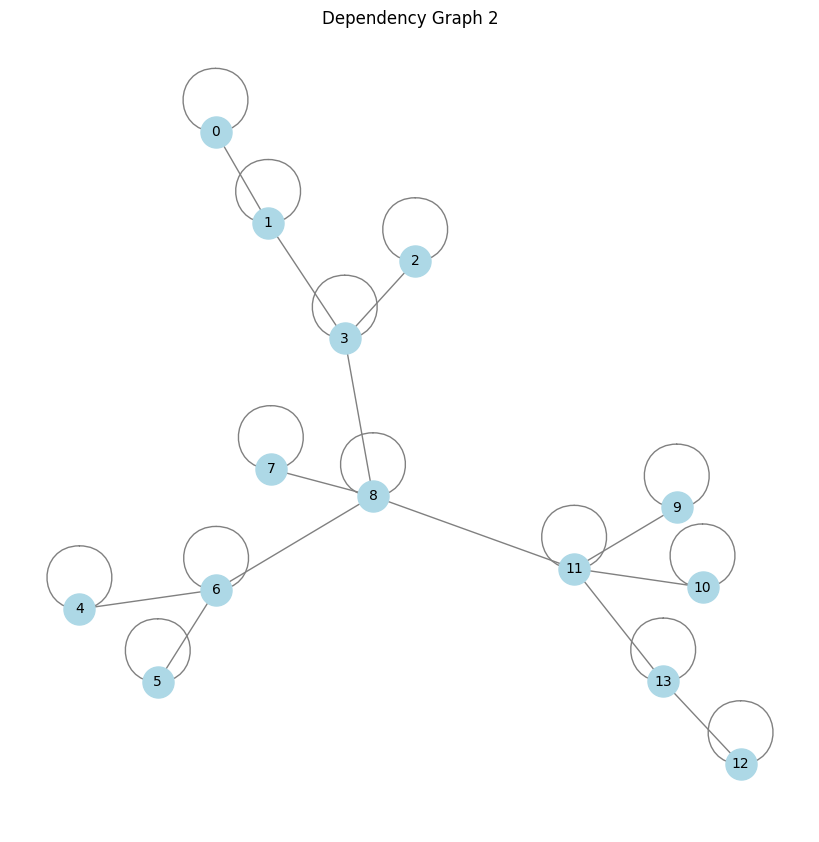

(14, 14)


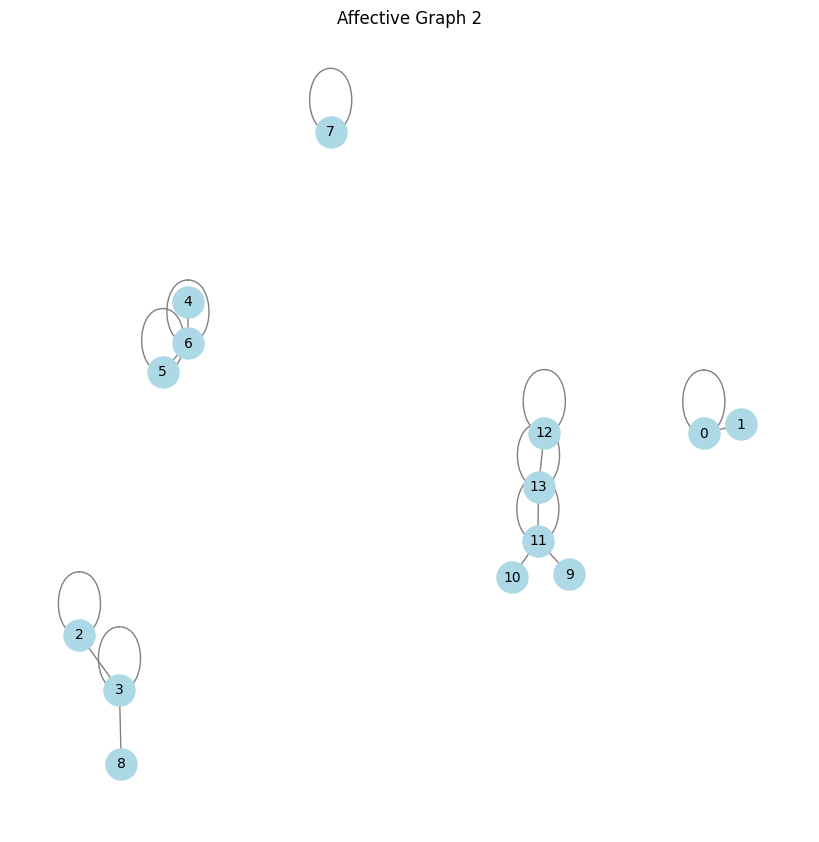

In [ ]:
# 可视化前几个图
for i in range(3):
    visualize_graph(dep_graphs[i], title=f'Dependency Graph {i}')
    print(dep_graphs[i].shape)
    visualize_graph(aff_graphs[i], title=f'Affective Graph {i}')

In [ ]:
dataset = create_dataset(dep_graphs, aff_graphs, labels)

# 将数据集分成训练集和测试集
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
print(train_dataset)

[Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0

In [ ]:
print(train_dataset)

[Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0, 50], edge_index=[2, 0], y=[1], edge_index_aff=[2, 0]), Data(x=[0

In [ ]:
# 训练 GCN
def train(model, data_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_index_aff)  # 直接传 batch，自动适配
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)


# 评估模型
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_index_aff)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    return correct / total


In [ ]:
# 让 PyG 自动处理不同大小的 batch
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=lambda batch: Batch.from_data_list(batch))

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# 设备设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化模型
input_dim = dep_graphs[0].shape[0]  # 以节点数作为输入维度
model = SarcasmGCN(input_dim=input_dim, hidden_dim=64, output_dim=2).to(device)

# 优化器 & 损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.NLLLoss()

# 训练模型
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(model, dataloader, optimizer, loss_fn, device)
    acc = evaluate(model, dataloader, device)
    print(f"Epoch {epoch+1}: Loss = {train_loss:.4f}, Accuracy = {acc:.4f}")




NameError: name 'x' is not defined